# Heading angle visualisation
## 0. Initialisation
(adjust path)

In [19]:
save_path = "/Users/aljoscha/Downloads/locustVR_data"
save_plots = True

import os,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind
from itertools import combinations
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
import importlib

plt.style.use('default')

from LocustVR_data_analysis import utils_local

importlib.reload(utils_local)
from LocustVR_data_analysis.utils_local import plt_density, default_style, generate_plot_type, generate_time_windows

In [20]:
df = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

In [25]:
print(df.columns)
print(df['state_type'].value_counts())
# print(df['trial_id'])
print(df['ts'].max())
print(df['heading_rel_flip'].min())

Index(['X', 'Y', 'heading', 'ts', 'trial_id', 'state_type', 'animal_id',
       'heading_rel', 'heading_rel_flip', 'constant_distance',
       'constant_speed', 'X_aligned', 'Y_aligned', 'Y_flip', 'directness',
       'angle_direct'],
      dtype='object')
state_type
1    4296909
2    4235002
0    3933486
Name: count, dtype: int64
9494
-3.1415912839212403


In [10]:
angle_version = ["heading_rel", "heading_rel_flip"]
select = ["data", "angle", "angular_velocity"]
plot_type = ["hist", "kde"] # Options: hist, kde

time_bins = [0,2,4,6,8]

sec = 100
limits = [[-3000 / sec, 9494 / sec], [-180, 180]]

angle_bins = np.linspace(-np.pi, np.pi, 360)  # 1° bins
time_ts = [0, 200, 400, 600, 800]

## 1 Angle over time / density heatmap

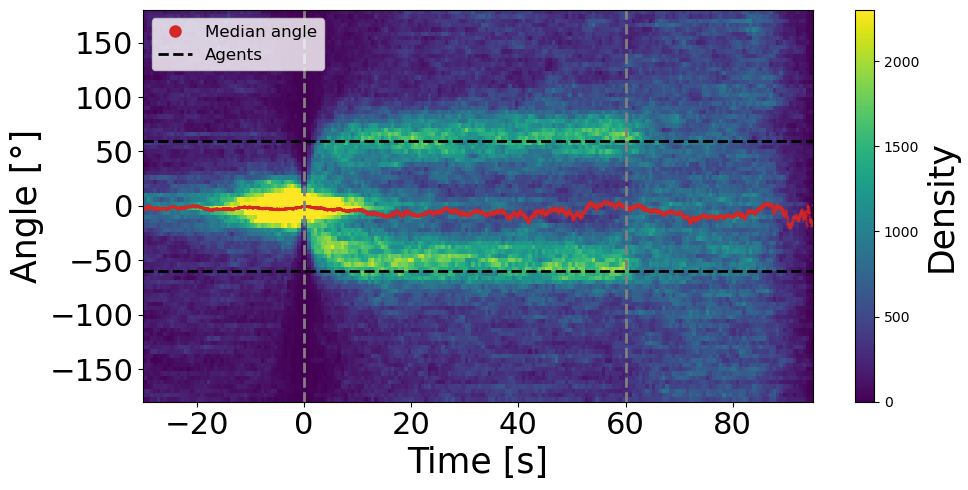

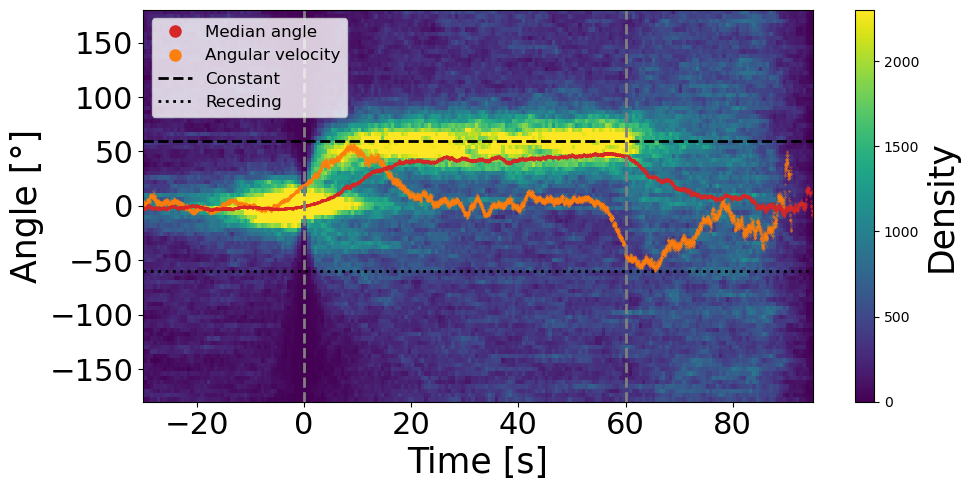

In [11]:
angle_version = ["heading_rel", "heading_rel_flip"]
v_max = 2300

for version in angle_version:
    fig, ax = plt.subplots(figsize=(10, 5))
    if "data" in select:
        # Prepare data
        x = df['ts'] / sec
        y = np.degrees(df[version])

        # Heatmap with log color normalization for better contrast
        heatmap = ax.hist2d(
            x, y,
            bins=[200, 90],  # time x angle resolution
            range=[[limits[0][0], limits[0][1]], [limits[1][0], limits[1][1]]],
            cmap='viridis',
            # norm=LogNorm(vmin=1, vmax=1000),
            density=False,
            vmax=v_max
        )

        cbar = fig.colorbar(heatmap[3], ax=ax)
        cbar.set_label("Density", fontsize=25)

    # Median angle
    df_mean = df.groupby('ts', as_index=False)[version].median()

    # Angular velocity
    df_median = df.groupby('ts', as_index=False)[version].median()
    df_median = df_median.sort_values('ts')
    df_median['heading_smooth'] = df_median[version].rolling(window=800, center=True).mean()
    df_median['angular_velocity'] = df_median['heading_smooth'].diff() / df_median['ts'].diff()
    df_median = df_median.dropna(subset=['angular_velocity'])
    if version == "heading_rel_flip":
        ax.scatter(df_median['ts'] / sec, np.degrees(df_median['angular_velocity'] * 1800), color='C1', label='angular velocity', s=0.05)
    ax.scatter(df_mean['ts'] / sec, 1 * np.degrees(df_mean[version]), color='C3', label='median angle', s=0.05)
    # ax.scatter(df_mean['ts'] / sec, 3 * np.degrees(df_mean[version]), color='C3', label='median angle', s=0.05)


    # ±60° reference
    ax.axhline(60, color='black', linestyle='--', label='constant distance', linewidth=2)
    if version == "heading_rel_flip":
        ax.axhline(-60, color='black', linestyle=':', label='constant speed', linewidth=2)
    else:
        ax.axhline(-60, color='black', linestyle='--', label='constant speed', linewidth=2)
    ax.axvline(0, color='grey', linestyle='--', linewidth=2)
    ax.axvline(60, color='grey', linestyle='--', linewidth=2)

    # Labels, limits, legend
    default_style(x_label="time [s]", y_label="angle [°]", limits=limits)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])

    legend_marker = mlines.Line2D([], [], color='C3', marker='o',
                              linestyle='None', markersize=8, label='Median angle')
    legend_marker2 = mlines.Line2D([], [], color='C1', marker='o',
                              linestyle='None', markersize=8, label='Angular velocity')
    if version == "heading_rel_flip":
        legend_marker3 = mlines.Line2D([], [], color='black', marker='None',
                                      linestyle='--', linewidth=2, label='Constant')
        legend_marker4 = mlines.Line2D([], [], color='black', marker='None',
                                      linestyle=':', linewidth=2, label='Receding')
    else: legend_marker3 = mlines.Line2D([], [], color='black', marker='None',
                                      linestyle='--', linewidth=2, label='Agents')

    if version == "heading_rel_flip":
        ax.legend(loc='upper left', handles=[legend_marker, legend_marker2, legend_marker3, legend_marker4], fontsize=12)
    else:
        ax.legend(loc='upper left', handles=[legend_marker, legend_marker3], fontsize=12)
    default_style(x_label="Time [s]", y_label="Angle [°]")
    if save_plots:
        plt.savefig(os.path.join(save_path, f'angle_vs_time_heatmap{version}1.png'), format='png', dpi=1000)
    plt.show()

## 2 Density of angles (for time bins)

### 2.1 default

heading_rel_flip


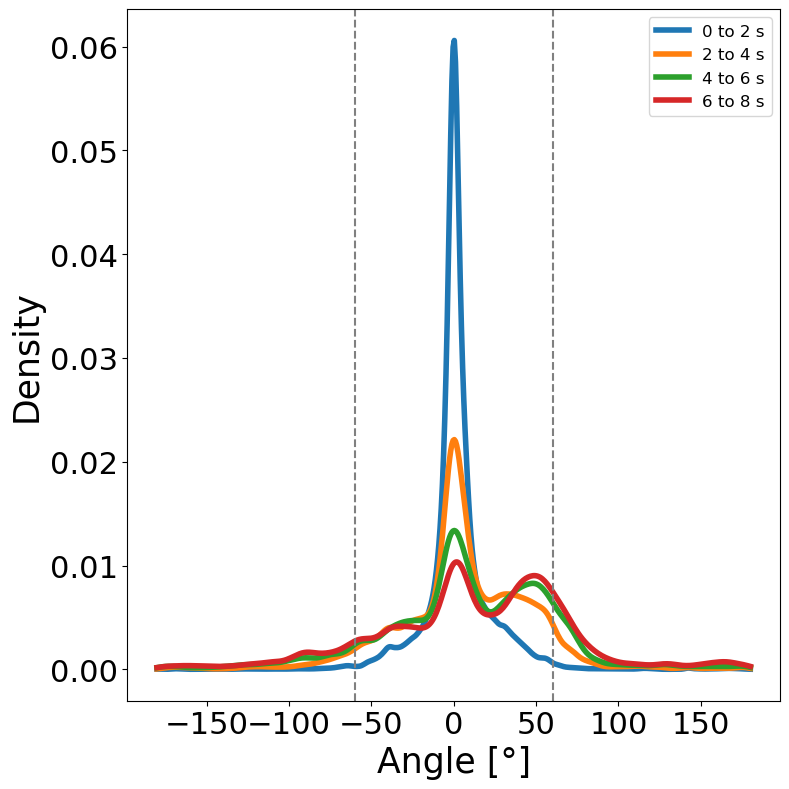

heading_rel


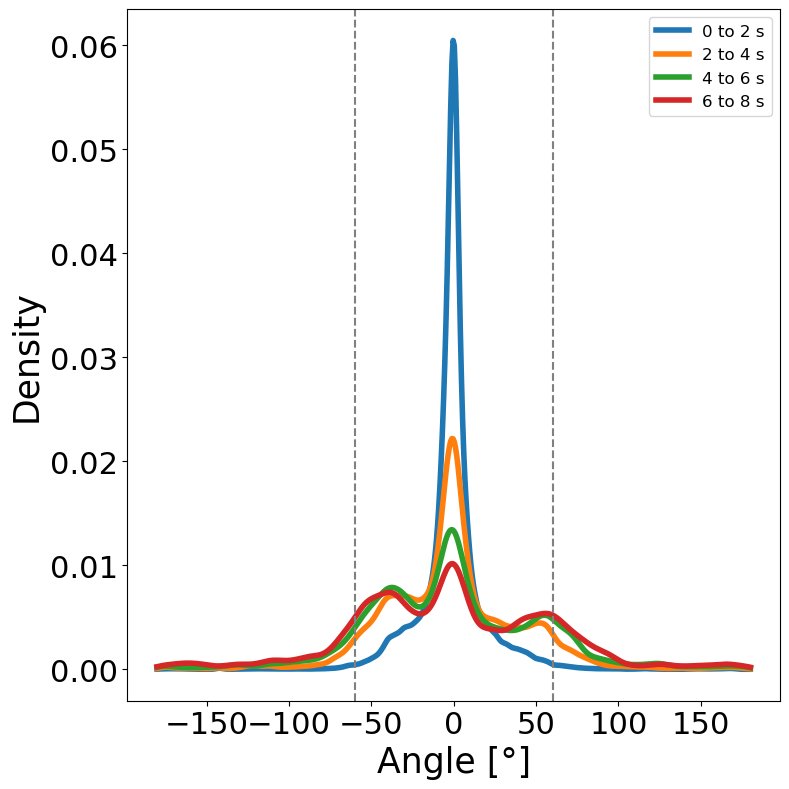

In [12]:
time_windows = generate_time_windows(time_bins)
plot_type = ["kde"]
angle_version = ["heading_rel_flip", "heading_rel"]
for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)
    for version in angle_version:
        print(version)
        plt.figure(figsize=(8, 8))
        plt_density(df, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
        default_style(x_label="Angle [°]", y_label="Density")
        if save_plots:
            plt.savefig(os.path.join(save_path, f'{type}_{version}.png'), format='png', dpi=1000)
        plt.show()

### 2.2 Per animal

Plot type: kde | Angle version: heading_rel_flip
  Plotting for animal: 0


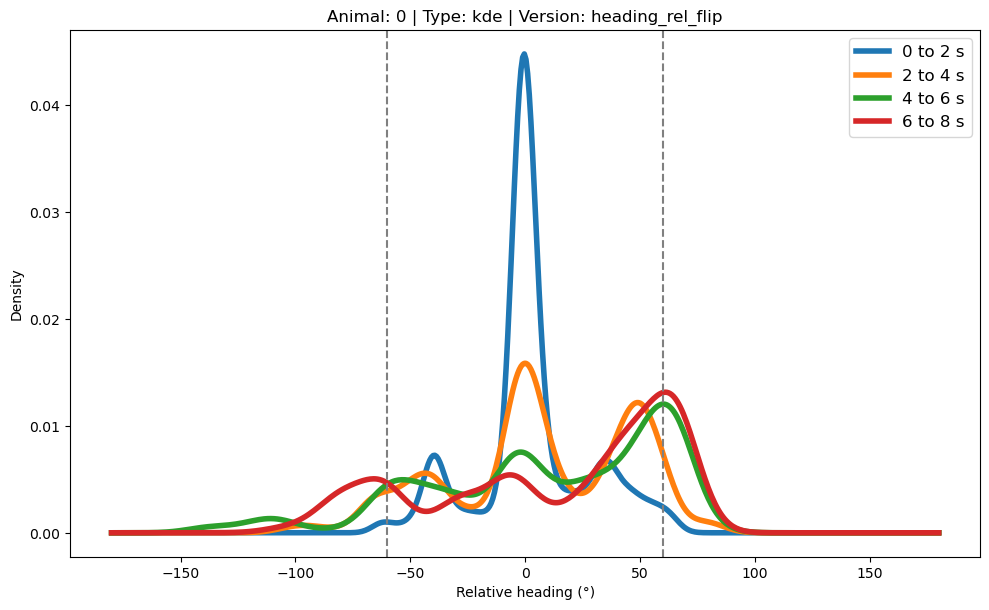

In [6]:
time_windows = generate_time_windows(time_bins)
plot_type = ["kde"]
angle_version = ["heading_rel_flip"]
df_sliced = df.loc[df["animal_id"] < 1, :]

for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)

    for version in angle_version:
        print(f"Plot type: {type} | Angle version: {version}")

        for animal_id, df_animal in df_sliced.groupby("animal_id"):
            print(f"  Plotting for animal: {animal_id}")

            plt.figure(figsize=(10, 6))
            plt_density(df_animal, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
            plt.title(f"Animal: {animal_id} | Type: {type} | Version: {version}")

            filename = f"{type}_{version}_animal_{animal_id}.png"
            if save_plots:
                plt.savefig(os.path.join(save_path, filename), format='png', dpi=500)
            plt.show()

### 2.3 Grouped by condition

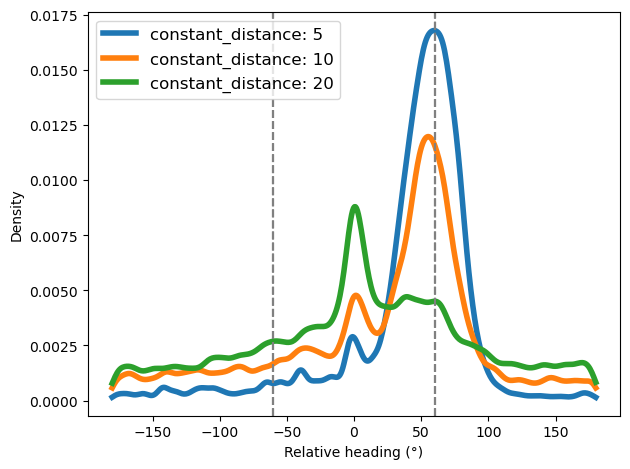

In [7]:
list_parameters = ["constant_distance"]

time_windows = generate_time_windows([0, 60])
for version in angle_version:
    def group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=False):
        grouped = df.groupby(list_parameters)
        for groupvalues, group in grouped:
            label2 = ""
            for i in range(len(list_parameters)):
                if i > 0:
                    label2 += ", "
                label2 += f"{list_parameters[i]}: {groupvalues[i]}"
            plt_density(group, version, time_windows, angle_bins, plt_hist , plt_kde,label2=label2)
        if plt_hist:
            plt.savefig(os.path.join(save_path, f'{list_parameters[i]}_{type}_{version}.png'), format='png', dpi=500)
        plt.show()
    group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=True)


## 3 Preference Index /  Regions of interest

In [8]:
def compute_heading_sectors(df, angle_col='heading_rel_flip', trial_col='trial_id', animal_col='animal_id', t_col='ts', speed_col='constant_speed', distance_col='constant_distance'):
    df = df.copy()

    mu = [-60, 60]
    threshold = 20

    # Define sector boundaries
    left_bounds = (mu[0] - threshold, mu[0] + threshold)
    right_bounds = (mu[1] - threshold, mu[1] + threshold)
    center_bounds = (left_bounds[1], right_bounds[0])

    result_rows = []

    # Filter by ts window
    df = df[(df[t_col] >= 1000) & (df[t_col] < 6000)].copy()
    df['angle_deg'] = np.degrees(df[angle_col])

    for (animal, trial), group in df.groupby([animal_col, trial_col]):
        angles = group['angle_deg'].to_numpy()

        # Sector counts
        count_left = np.sum((angles >= left_bounds[0]) & (angles <= left_bounds[1]))
        count_right = np.sum((angles >= right_bounds[0]) & (angles <= right_bounds[1]))
        count_center = np.sum((angles > center_bounds[0]) & (angles < center_bounds[1]))
        count_outside = len(angles) - (count_left + count_right + count_center)

        # Determine dominant sector
        count_else = count_center + count_outside
        counts_comp = np.array([count_left, count_right, count_else])
        sectors_comp = ['left', 'right', 'else']
        most_common_sector = sectors_comp[np.argmax(counts_comp)]

        total = len(angles)

        # Summarize constant_speed and constant_distance (use mean here)
        mean_speed = group[speed_col].mean()
        mean_distance = group[distance_col].mean()

        result_rows.append({
            'animal_id': animal,
            'trial_id': trial,
            'count_left': count_left,
            'count_right': count_right,
            'count_center': count_center,
            'count_outside': count_outside,
            'fraction_left': count_left / total,
            'fraction_right': count_right / total,
            'fraction_center': count_center / total,
            'fraction_outside': count_outside / total,
            'most_common_sector': most_common_sector,
            'mean_constant_speed': round(mean_speed),
            'mean_constant_distance': round(mean_distance)
        })

    return pd.DataFrame(result_rows)

# Usage
results = compute_heading_sectors(df)
print(list(results))

['animal_id', 'trial_id', 'count_left', 'count_right', 'count_center', 'count_outside', 'fraction_left', 'fraction_right', 'fraction_center', 'fraction_outside', 'most_common_sector', 'mean_constant_speed', 'mean_constant_distance']


### 3.1 All conditions

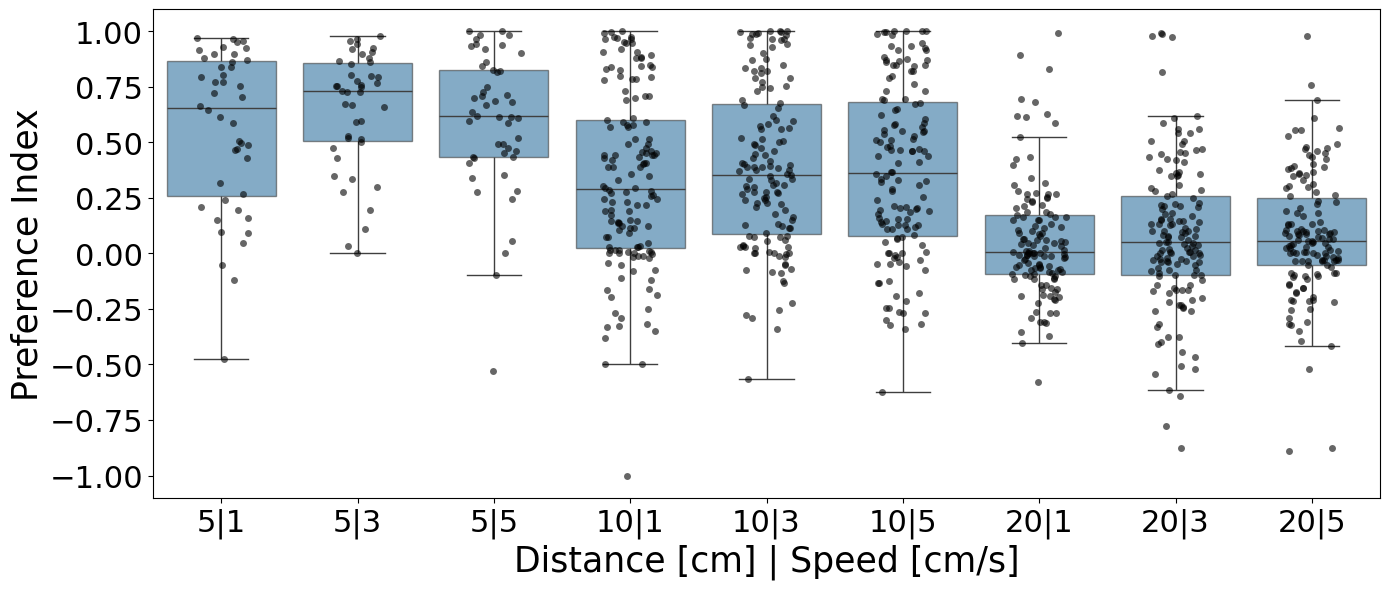

In [9]:

# --- Compute PI for each row ---
results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]
results["target"] = results["fraction_left"] + results["fraction_right"]

# Avoid division by zero
denominator = results["fraction_left"] + results["fraction_right"] + results["fraction_else"]
# denominator = results["fraction_else"] + results["target"]
results["preference_index"] = (results["fraction_right"] - results["fraction_left"]) / denominator.replace(0, np.nan)
# results["preference_index"] = (results["target"] - results["fraction_else"]) / denominator.replace(0, np.nan)

# Bin speed and distance for grouping
results["speed_bin"] = results["mean_constant_speed"].round(2)
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Create group label
results["group_label"] = results["distance_bin"].astype(str) + "|" + results["speed_bin"].astype(str)

# Sort by numeric bins
sorted_df = results.sort_values(["distance_bin", "speed_bin"])
label_order = sorted_df["group_label"].drop_duplicates()

# Then plot using the correct order
plt.figure(figsize=(14, 6))
sns.boxplot(x="group_label", y="preference_index", data=results,
            showfliers=False, boxprops={'alpha':0.6},
            order=label_order)
sns.stripplot(x="group_label", y="preference_index", data=results,
              color='black', alpha=0.6, jitter=0.2,
              order=label_order)

default_style(x_label="", y_label="")
# plt.xticks(rotation=45)
plt.ylabel("Preference Index")
plt.xlabel("Distance [cm] | Speed [cm/s]")
# plt.title("Preference Index by Distance and Speed")
plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(save_path, f'22.png'), format='png', dpi=1000)
plt.show()

### 3.2 Compare per parameter (with significances - Man-Witney-U)

Mann-Whitney U test between 5 and 10: p = 0.0000000001088720838168636556972231158599631606342938994202995673
Mann-Whitney U test between 5 and 20: p = 0.0000000000000000000000000000000000000000338680961529482457416176
Mann-Whitney U test between 10 and 20: p = 0.0000000000000000000000000001472646239963348054651849981218243163


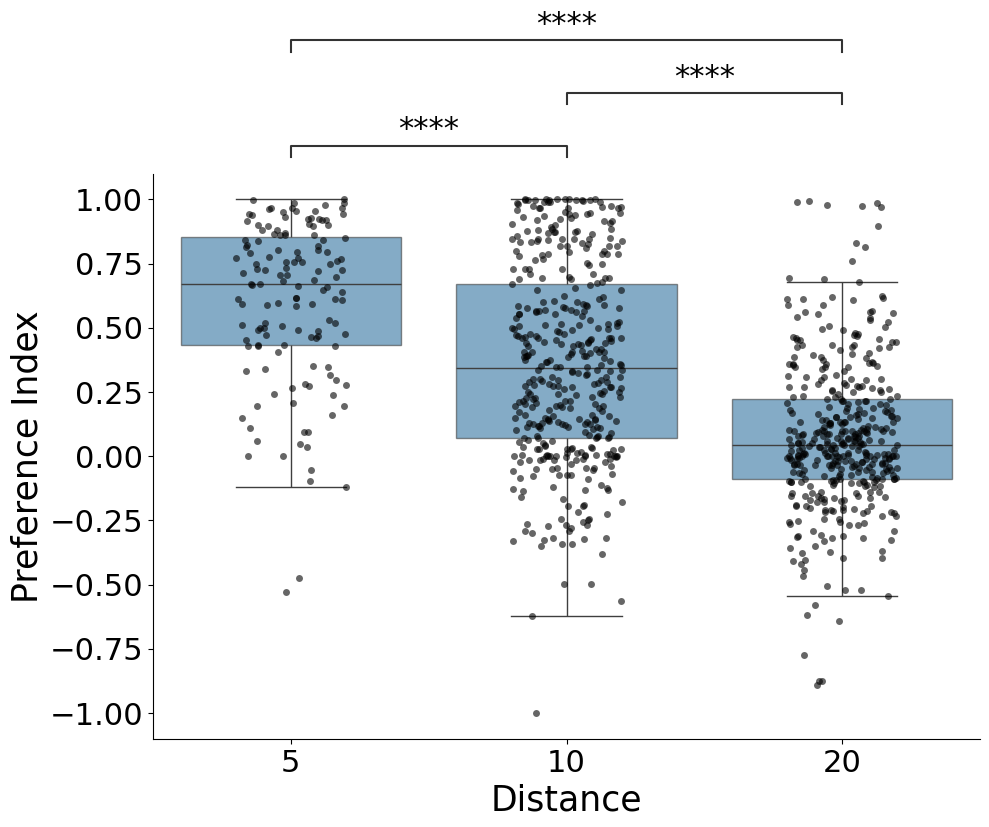

Mann-Whitney U test between 1 and 3: p = 0.1254200778599260657220071379924775101244449615478515625000000000
Mann-Whitney U test between 1 and 5: p = 0.1943541255745284690448215769720263779163360595703125000000000000
Mann-Whitney U test between 3 and 5: p = 0.8546407484731640691322240854788105934858322143554687500000000000


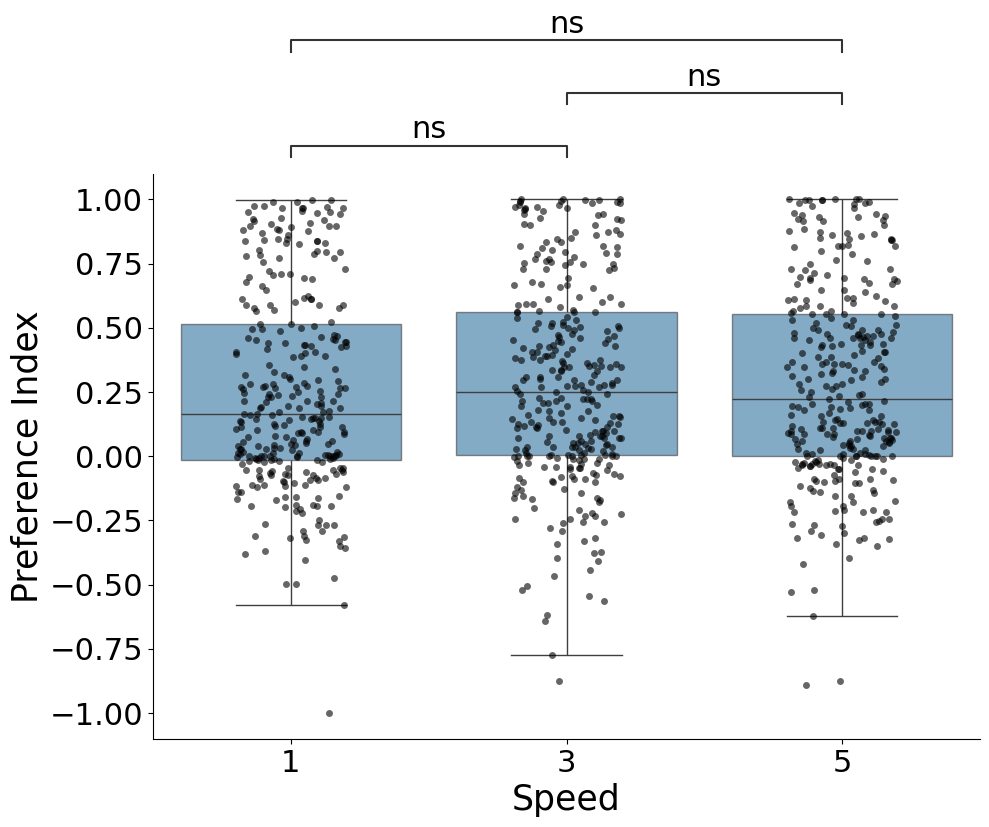

Mann-Whitney U test between 5 and 10: p = 0.0000000082177594493616545811442934536296400782617865843349136412
Mann-Whitney U test between 5 and 20: p = 0.0000000000000000000000000000000000031193040324281685651680166242
Mann-Whitney U test between 10 and 20: p = 0.0000000000000000000000012235471035350378999521229113486265999737


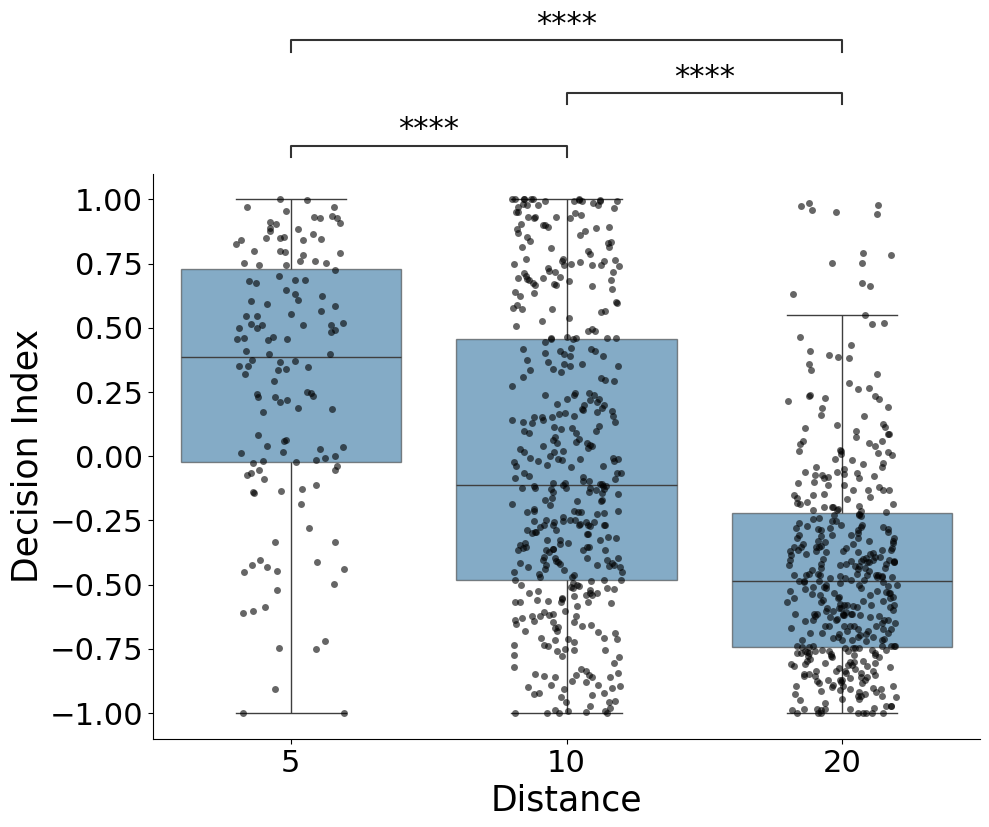

Mann-Whitney U test between 1 and 3: p = 0.3681073303780405536755893081135582178831100463867187500000000000
Mann-Whitney U test between 1 and 5: p = 0.3473518855220237844250164016557391732931137084960937500000000000
Mann-Whitney U test between 3 and 5: p = 0.9828441027985984623782655944523867219686508178710937500000000000


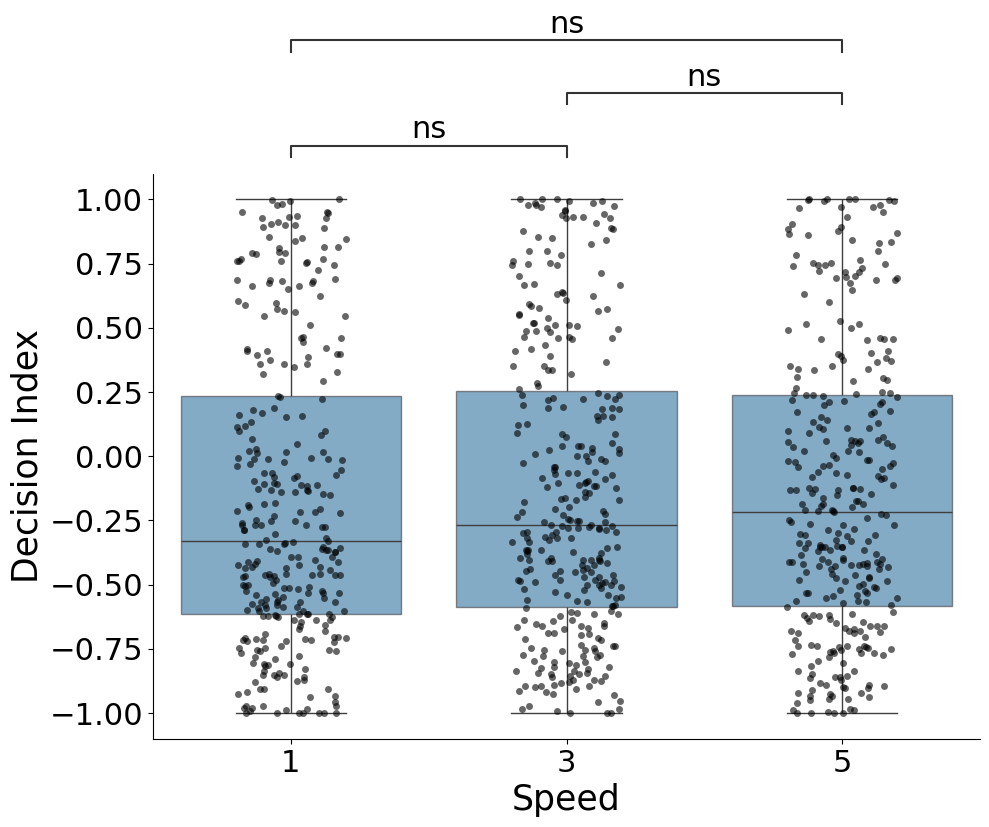

In [10]:
parameter1 = ["perference", "decision"]
parameter2 = ["distance", "speed"]
for par1 in parameter1:
    for par2 in parameter2:

# --- Compute PI for each row ---
        if par1 == "perference":
            results["target"] = results["fraction_left"] + results["fraction_right"]
            denominator = results["fraction_left"] + results["fraction_right"] + results["fraction_else"]
            results["preference_index"] = (results["fraction_right"] - results["fraction_left"]) / denominator.replace(0, np.nan)
        elif par1 == "decision":
            results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]
            denominator = results["fraction_else"] + results["target"]
            results["preference_index"] = (results["target"] - results["fraction_else"]) / denominator.replace(0, np.nan)

        # Bin distances only
        if par2 == "distance":
            results["distance_bin"] = results["mean_constant_distance"].round(2)
        elif par2 == "speed":
            results["distance_bin"] = results["mean_constant_speed"].round(2)

        distance_order = sorted(results["distance_bin"].unique())

        # --- Plot ---
        plt.figure(figsize=(10, 9))
        ax = sns.boxplot(x="distance_bin", y="preference_index", data=results,
                         showfliers=False, boxprops={'alpha': 0.6}, order=distance_order)

        sns.stripplot(x="distance_bin", y="preference_index", data=results,
                      color='black', alpha=0.6, jitter=0.2, order=distance_order)

        # from scipy.stats import normaltest
        #
        # # --- Normality check per group (for larger sample sizes) ---
        # normality_results = {}
        #
        # for bin_value in distance_order:
        #     group_data = results[results["distance_bin"] == bin_value]["preference_index"].dropna()
        #
        #     # Visual inspection (optional)
        #     plt.figure()
        #     sns.histplot(group_data, kde=True)
        #     plt.title(f'Histogram for bin {bin_value}')
        #     plt.xlabel("Preference Index")
        #     plt.ylabel("Frequency")
        #     plt.tight_layout()
        #     plt.show()
        #
        #     if len(group_data) >= 8:  # normaltest requires at least 8 samples
        #         stat, p = normaltest(group_data)
        #         normality_results[bin_value] = p
        #         print(f"D’Agostino and Pearson test for bin {bin_value}: p = {p:.4f} {'(normal)' if p > 0.05 else '(not normal)'}")
        #     else:
        #         print(f"Not enough data for normality test in bin {bin_value}")

        # --- Significance testing ---

        pairs = list(combinations(distance_order, 2))
        p_values = []

        for d1, d2 in pairs:
            group1 = results[results["distance_bin"] == d1]["preference_index"].dropna()
            group2 = results[results["distance_bin"] == d2]["preference_index"].dropna()

            if len(group1) >= 1 and len(group2) >= 1:
                stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
                print(f"Mann-Whitney U test between {d1} and {d2}: p = {p:.64f}")
                p_values.append(p)
            else:
                p_values.append(np.nan)
                print(f"Skipping test between {d1} and {d2}: insufficient data")

        # Annotate significance

        default_style(x_label="", y_label="")

        annotator = Annotator(ax, pairs, data=results, x="distance_bin", y="preference_index", order=distance_order)
        annotator.configure(test=None, text_format='star', loc='outside', verbose=0, fontsize=22)
        annotator.set_pvalues(p_values)
        annotator.annotate()

        # Final plot adjustments
        if par1 == "perference":
            plt.ylabel("Preference Index")
        elif par1 == "decision":
            plt.ylabel("Decision Index")

        if par2 == "distance":
            plt.xlabel("Distance")
        elif par2 == "speed":
            plt.xlabel("Speed")
        # plt.title("Preference Index by Distance")
        plt.tight_layout()
        ax = plt.gca()
        ax.spines[['right', 'top']].set_visible(False)
        if save_plots:
            plt.savefig(os.path.join(save_path, f'box{par1}_{par2}.png'), format='png', dpi=1000)
        plt.show()

### 3.3 3D summary

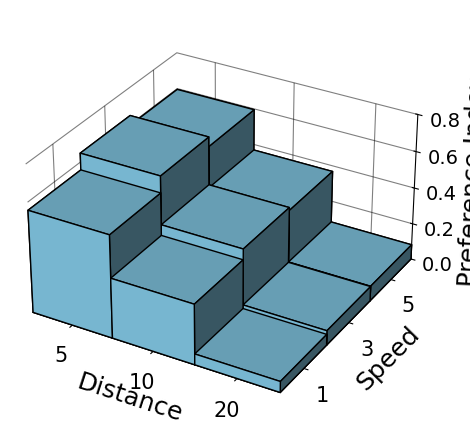

In [11]:
# --- Prepare data ---
results["fraction_else"] = results["fraction_center"] + results["fraction_outside"]
results["target"] = results["fraction_left"] + results["fraction_right"]

# Avoid division by zero
denominator = results["target"] + results["fraction_else"]
results["preference_index"] = (results["fraction_right"] - results["fraction_left"]) / denominator.replace(0, np.nan)

# Bin speed and distance (round to 2 decimals — adapt if needed)
results["speed_bin"] = results["mean_constant_speed"].round(2)
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Use sorted unique bins to create a grid
speed_bins = np.sort(results["speed_bin"].unique())
distance_bins = np.sort(results["distance_bin"].unique())

# Create mapping of bins to grid positions (0,1,2)
speed_bin_map = {val: i for i, val in enumerate(speed_bins)}
distance_bin_map = {val: i for i, val in enumerate(distance_bins)}

# Group and average
grouped = results.groupby(["distance_bin", "speed_bin"])["preference_index"].mean().reset_index()

# Prepare 3×3 grid data
x_vals = [distance_bin_map[d] for d in grouped["distance_bin"]]
y_vals = [speed_bin_map[s] for s in grouped["speed_bin"]]
z_vals = grouped["preference_index"].values

dx = dy = 1  # Equal width/height
dz = z_vals

# --- Create 3D Plot ---
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_position([0.1, 0.1, 0.7, 0.7])  # Expand width

# Plot bars
ax.bar3d(x_vals, y_vals, np.zeros_like(dz), dx, dy, dz, shade=True, color='skyblue', edgecolor='k')

# Ticks and labels
ax.set_xticks(np.arange(0.5, 3.5, 1))
ax.set_xticklabels(distance_bins)
ax.set_yticks(np.arange(0.5, 3.5, 1))
ax.set_yticklabels(speed_bins)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_zlim(0, 0.8)
ax.set_box_aspect((1, 1, 0.6))

# Clean up background
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)
ax.xaxis._axinfo["grid"]['color'] = (0,0,0,0.5)
ax.yaxis._axinfo["grid"]['color'] = (0,0,0,0.5)
ax.zaxis._axinfo["grid"]['color'] = (0,0,0,0.5)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='z', labelsize=14)

# Axis labels
ax.set_xlabel("Distance", fontsize=18)
ax.set_ylabel("Speed", fontsize=18)
ax.set_zlabel("Preference Index", fontsize=18)
# ax.set_title("Preference Index Grid")
if save_plots:
    plt.savefig(os.path.join(save_path, '3d.png'), format='png', dpi=500)
plt.show()

## 4 Fraction ROI

### 4.1 All conditions

/var/folders/yv/pwckh1jd1q7_mprkvx3pxgnm0000gp/T/ipykernel_13549/3719749594.py:25: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


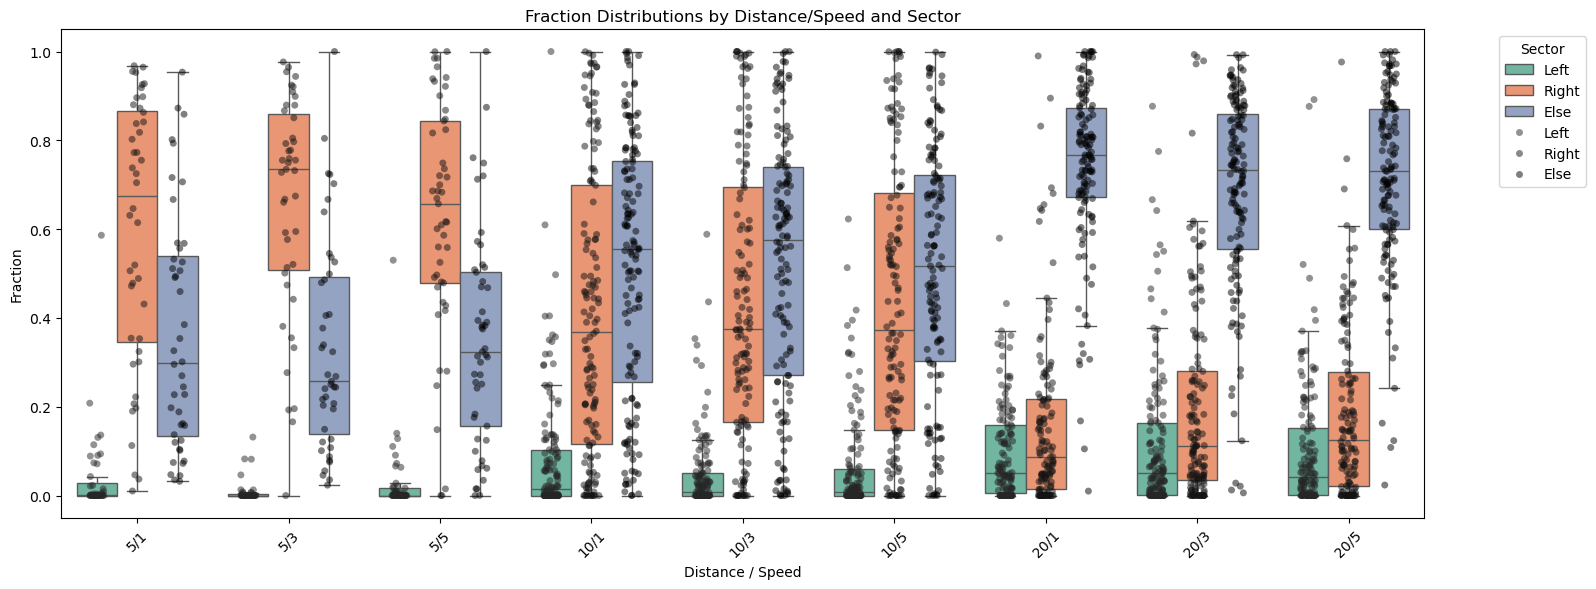

In [12]:
# Combine the label
results["group_label"] = results["distance_bin"].astype(str) + "/" + results["speed_bin"].astype(str)

# Melt to long format
melted = pd.melt(
    results,
    id_vars=["group_label"],
    value_vars=["fraction_left", "fraction_right", "fraction_else"],
    var_name="fraction_type",
    value_name="value"
)

# Clean names
melted["fraction_type"] = melted["fraction_type"].str.replace("fraction_", "").str.capitalize()

# Sort group labels
sorted_labels = results.sort_values(["distance_bin", "speed_bin"])["group_label"].drop_duplicates()

# Plot
plt.figure(figsize=(16, 6))
sns.boxplot(
    x="group_label", y="value", hue="fraction_type", data=melted,
    showfliers=False, palette="Set2", order=sorted_labels
)
sns.stripplot(
    x="group_label", y="value", hue="fraction_type", data=melted,
    dodge=True, jitter=0.15, color='black', alpha=0.5, order=sorted_labels
)

plt.xticks(rotation=45)
plt.xlabel("Distance / Speed")
plt.ylabel("Fraction")
plt.title("Fraction Distributions by Distance/Speed and Sector")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4.2 Only distance

/var/folders/yv/pwckh1jd1q7_mprkvx3pxgnm0000gp/T/ipykernel_13549/290835337.py:22: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


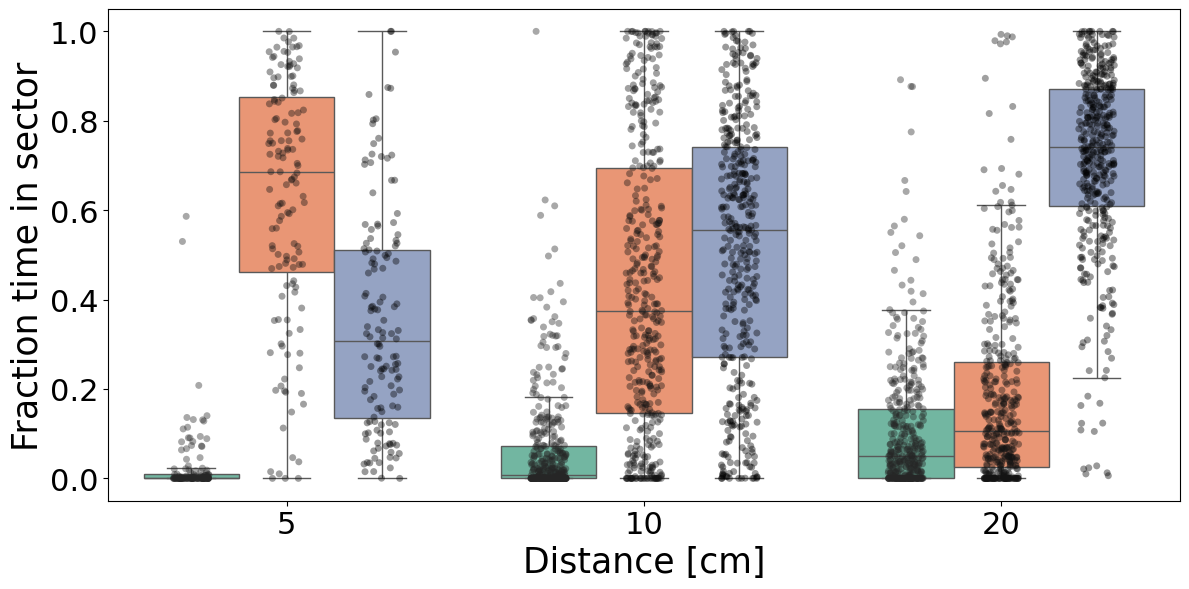

In [13]:
# --- Prepare grouping only by distance ---
results["distance_bin"] = results["mean_constant_distance"].round(2)

# Melt to long format
melted = pd.melt(
    results,
    id_vars=["distance_bin"],
    value_vars=["fraction_left", "fraction_right", "fraction_else"],
    var_name="fraction_type",
    value_name="value"
)

# Clean names for display
melted["fraction_type"] = melted["fraction_type"].str.replace("fraction_", "").str.capitalize()

# --- Plot setup ---
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x="distance_bin", y="value", hue="fraction_type", data=melted,
    showfliers=False, palette="Set2"
)
sns.stripplot(
    x="distance_bin", y="value", hue="fraction_type", data=melted,
    dodge=True, jitter=0.15, color='black', alpha=0.4
)

# --- Final adjustments ---
default_style(y_label="Fraction time in sector", x_label="Distance [cm]")

plt.tight_layout()
ax.get_legend().remove()
if save_plots:
    plt.savefig(os.path.join(save_path, 'Set2.png'), format='png', dpi=1000)
plt.show()

## 5 Angular velocity

In [14]:
def compute_max_angular_velocity(df, angle_col='heading_rel_flip', trial_col='trial_id',
                                 animal_col='animal_id', t_col='ts', distance_col='constant_distance',
                                 smoothing_sigma=300):
    df = df.copy()
    result_rows = []

    for (animal, trial), group in df.groupby([animal_col, trial_col]):
        # Filter for extended time window
        extended_group = group[(group[t_col] >= -800) & (group[t_col] <= 1600)].copy()

        # Sort by time just in case
        extended_group = extended_group.sort_values(by=t_col)

        # Convert to degrees for better interpretability (optional)
        extended_group['angle_deg'] = np.degrees(extended_group[angle_col])

        # Smooth the angle signal
        smoothed_angle = gaussian_filter1d(extended_group['angle_deg'].to_numpy(), sigma=smoothing_sigma)

        # Compute time differences
        ts_vals = extended_group[t_col].to_numpy()
        dt = np.gradient(ts_vals)
        dtheta = np.gradient(smoothed_angle)
        angular_velocity = dtheta / dt

        # Add angular velocity to dataframe
        extended_group['angular_velocity'] = angular_velocity

        # Select only the time window of interest
        focused = extended_group[(extended_group[t_col] >= 0) & (extended_group[t_col] <= 800)]

        # Add angular velocity column to the focused time window (0–1000)
        focused = extended_group[(extended_group[t_col] >= 0) & (extended_group[t_col] <= 800)].copy()
        focused['angular_velocity'] = angular_velocity[
            (ts_vals >= 0) & (ts_vals <= 800)
        ]

        # Drop NaNs before finding the max
        valid_ang_vel = focused.dropna(subset=['angular_velocity'])

        if not valid_ang_vel.empty:
            max_idx = valid_ang_vel['angular_velocity'].abs().idxmax()
            max_ang_vel = valid_ang_vel.loc[max_idx]['angular_velocity']
            max_ts = valid_ang_vel.loc[max_idx][t_col]
        else:
            max_ang_vel = np.nan
            max_ts = np.nan

        mean_distance = group[distance_col].mean()

        result_rows.append({
            'animal_id': animal,
            'trial_id': trial,
            'max_angular_velocity': max_ang_vel,
            'ts_at_max_velocity': max_ts,
            'mean_constant_distance': round(mean_distance)
        })

    return pd.DataFrame(result_rows)

results2 = compute_max_angular_velocity(df, angle_col='heading_rel_flip', trial_col='trial_id',
                                 animal_col='animal_id', t_col='ts', distance_col='constant_distance',
                                 smoothing_sigma=300)
results2 = results2.loc[results2["ts_at_max_velocity"] !=0, :]
results2 = results2.loc[results2["ts_at_max_velocity"] !=800, :]

### 5.1 max angular velocity first 8s

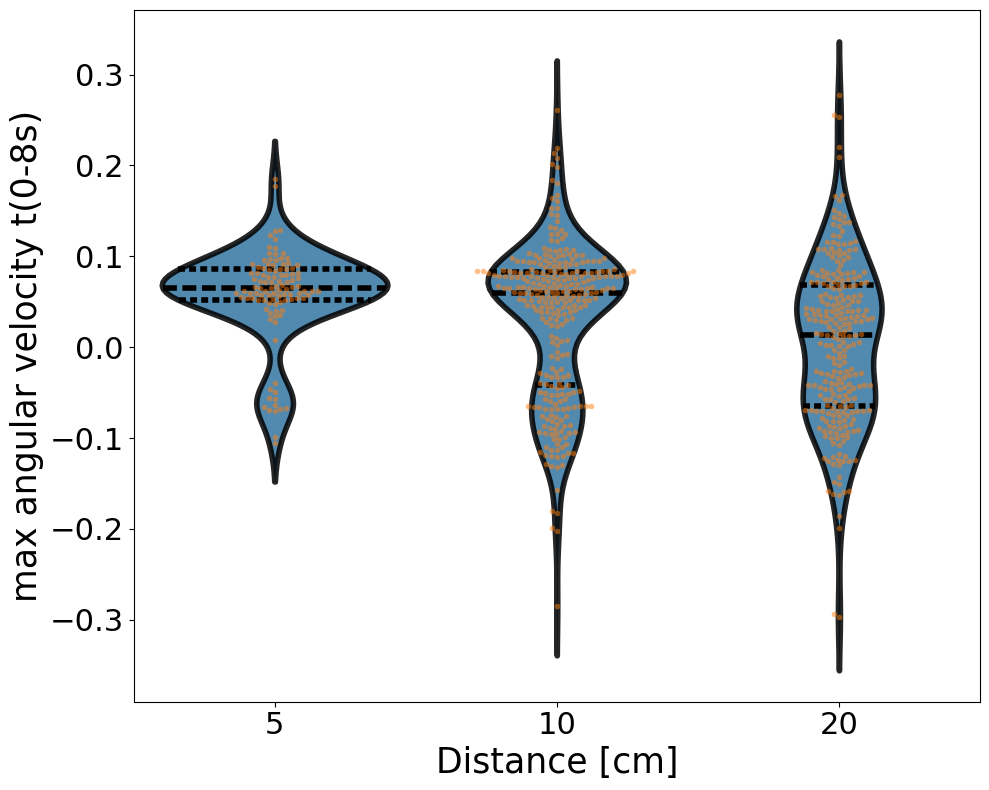

In [15]:
distance_order = sorted(results2["mean_constant_distance"].unique())
plt.figure(figsize=(10, 8))
# ax = sns.boxplot(x="mean_constant_distance", y="max_angular_velocity", data=results2,
#                  showfliers=False, boxprops={'alpha': 0.6}, order=distance_order)
sns.violinplot(x="mean_constant_distance", y="max_angular_velocity", data=results2, inner="quartile", order=distance_order, linewidth=4, edgecolor="black", alpha=0.85)
# sns.stripplot(x="mean_constant_distance", y="max_angular_velocity", data=results2,
#               color='black', alpha=0.6, jitter=0.2, order=distance_order)
sns.swarmplot(x="mean_constant_distance", y="max_angular_velocity",
              data=results2, color='C1', size=4, order=distance_order, alpha=0.5)
default_style(x_label="Distance [cm]", y_label="max angular velocity t(0-8s)")
if save_plots:
    plt.savefig(os.path.join(save_path, f'34.png'), format='png', dpi=1000)
plt.show()

### 5.2 Corresponding timestamp

[np.int64(5), np.int64(10), np.int64(20)]


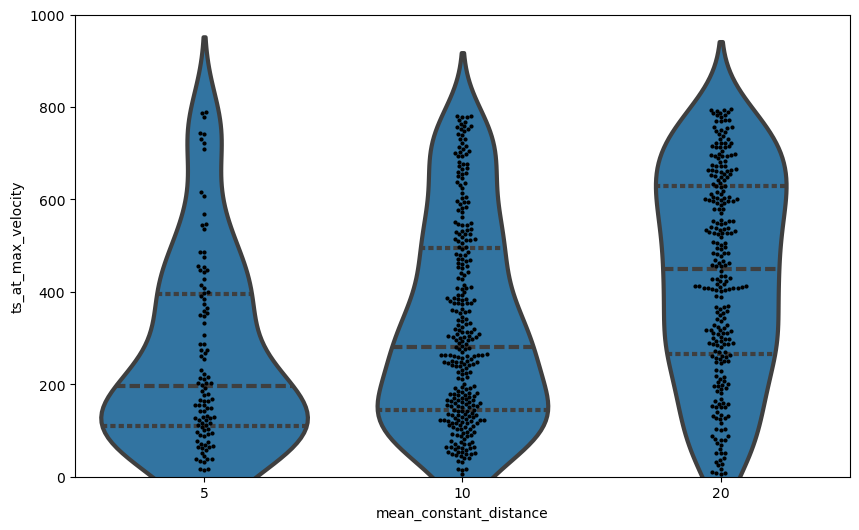

In [16]:
distance_order = sorted(results2["mean_constant_distance"].unique())
print(distance_order)
plt.figure(figsize=(10, 6))
# ax = sns.boxplot(x="mean_constant_distance", y="max_angular_velocity", data=results2,
#                  showfliers=False, boxprops={'alpha': 0.6}, order=distance_order)
sns.violinplot(x="mean_constant_distance", y="ts_at_max_velocity", data=results2, inner="quartile", linewidth=3, order=distance_order)
# sns.stripplot(x="mean_constant_distance", y="max_angular_velocity", data=results2,
#               color='black', alpha=0.6, jitter=0.2, order=distance_order)
sns.swarmplot(x="mean_constant_distance", y="ts_at_max_velocity",
              data=results2, color='black', size=3, order=distance_order)
plt.ylim(0,1000)
plt.show()

## 6 Cosine similarity

### 6.1 Over time

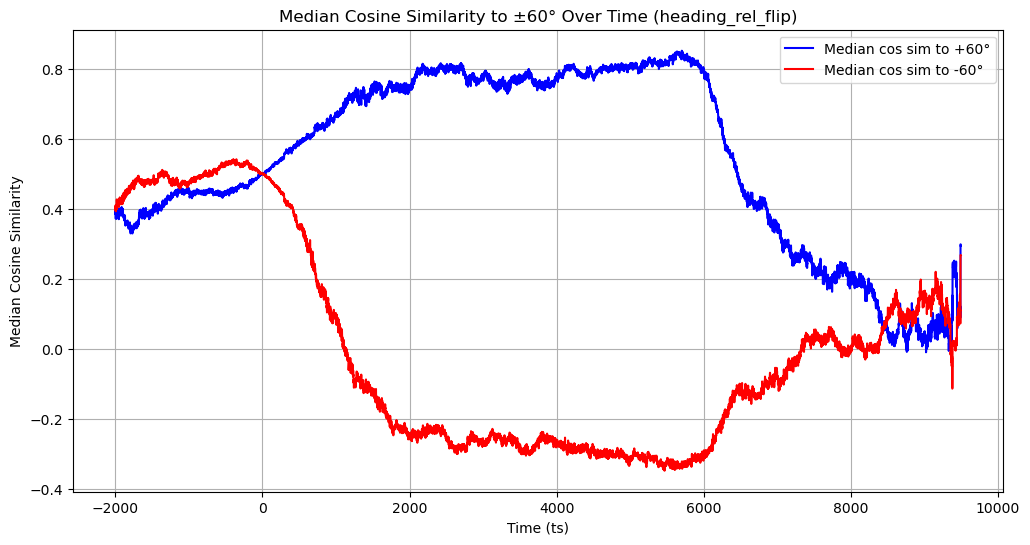

In [17]:
# Filter the DataFrame for the relevant time window
plot_df = df[(df['ts'] >= -2000) & (df['ts'] <= 9494)].copy()

# Reference angles in radians
ref_pos = np.radians(60)
ref_neg = np.radians(-60)

# Calculate cosine similarities
plot_df['cos_sim_pos60'] = np.cos(plot_df['heading_rel_flip'] - ref_pos)
plot_df['cos_sim_neg60'] = np.cos(plot_df['heading_rel_flip'] - ref_neg)

# Group by timestamp and compute the median cosine similarity
median_cos_sim = plot_df.groupby('ts')[['cos_sim_pos60', 'cos_sim_neg60']].median().reset_index()

# Plot median cosine similarity over time
plt.figure(figsize=(12, 6))
plt.plot(median_cos_sim['ts'], median_cos_sim['cos_sim_pos60'], label='Median cos sim to +60°', color='blue')
plt.plot(median_cos_sim['ts'], median_cos_sim['cos_sim_neg60'], label='Median cos sim to -60°', color='red')

plt.xlabel('Time (ts)')
plt.ylabel('Median Cosine Similarity')
plt.title('Median Cosine Similarity to ±60° Over Time (heading_rel_flip)')
plt.legend()
plt.grid(True)
plt.show()

### 6.2 Cos similarity per condition violin plots

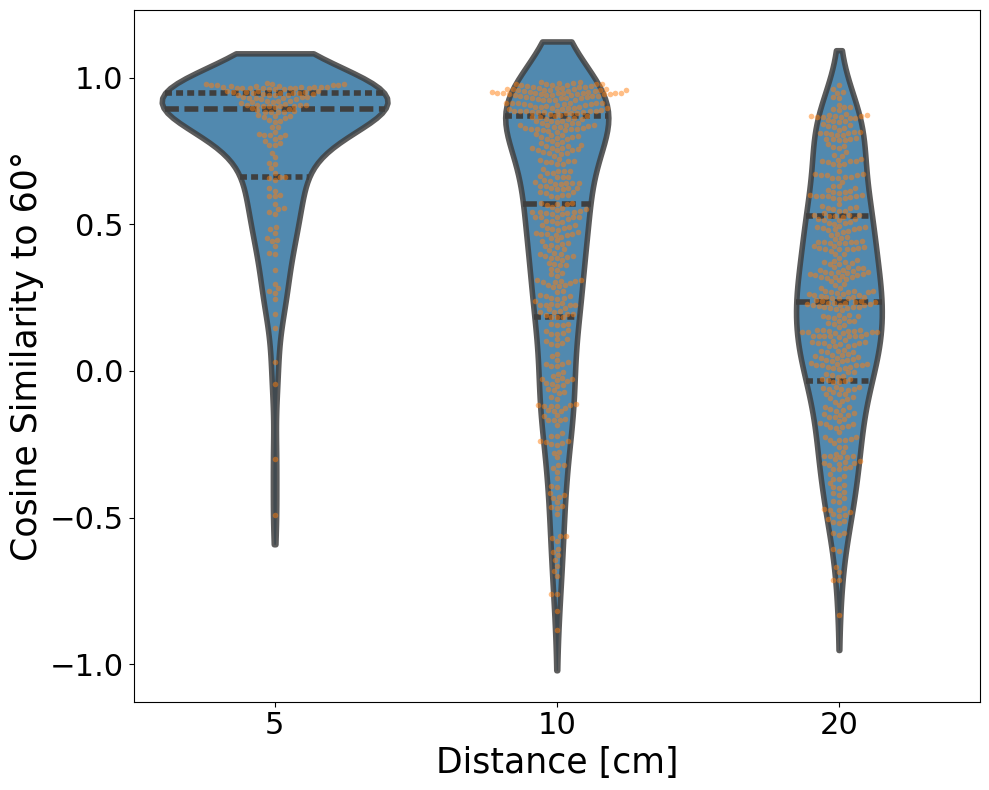

In [18]:
def compute_heading_similarity_with_resultant(df, angle_col='heading_rel_flip',
                                              animal_col='animal_id', trial_col='trial_id',
                                              distance_col='constant_distance', t_col='ts'):
    df = df.copy()

    # Filter time window [0, 6000]
    df = df[(df[t_col] >= 0) & (df[t_col] <= 6000)].copy()

    # Reference angles in radians
    ref_pos = np.radians(60)
    ref_neg = np.radians(-60)

    # Compute cosine similarity to each reference
    df['cos_sim_pos60'] = np.cos(df[angle_col] - ref_pos)
    df['cos_sim_neg60'] = np.cos(df[angle_col] - ref_neg)

    # Group by animal and trial
    result_rows = []
    for (animal, trial), group in df.groupby([animal_col, trial_col]):
        # Mean cosine similarity
        mean_sim_pos = group['cos_sim_pos60'].mean()
        mean_sim_neg = group['cos_sim_neg60'].mean()

        # # Resultant vector length for direction toward +60°
        # delta_pos = group[angle_col] - ref_pos
        # R_pos = np.sqrt(np.mean(np.cos(delta_pos))**2 + np.mean(np.sin(delta_pos))**2)
        #
        # # Resultant vector length for direction toward -60°
        # delta_neg = group[angle_col] - ref_neg
        # R_neg = np.sqrt(np.mean(np.cos(delta_neg))**2 + np.mean(np.sin(delta_neg))**2)
        # # Mean constant distance
        mean_distance = group[distance_col].mean()

        result_rows.append({
            'animal_id': animal,
            'trial_id': trial,
            'mean_cos_sim_to_60': mean_sim_pos,
            'mean_cos_sim_to_-60': mean_sim_neg,
            # 'R_to_60': R_pos,
            # 'R_to_-60': R_neg,
            'mean_constant_distance': round(mean_distance)
        })

    return pd.DataFrame(result_rows)

# import seaborn as sns
# distance_order = sorted(results2["mean_constant_distance"].unique())
# plt.figure(figsize=(10, 8))
# # ax = sns.boxplot(x="mean_constant_distance", y="max_angular_velocity", data=results2,
# #                  showfliers=False, boxprops={'alpha': 0.6}, order=distance_order)
# sns.violinplot(x="mean_constant_distance", y="max_angular_velocity", data=results2, inner="quartile", order=distance_order, linewidth=4, edgecolor="black", alpha=0.85)
# # sns.stripplot(x="mean_constant_distance", y="max_angular_velocity", data=results2,
# #               color='black', alpha=0.6, jitter=0.2, order=distance_order)
# sns.swarmplot(x="mean_constant_distance", y="max_angular_velocity",
#               data=results2, color='C1', size=4, order=distance_order, alpha=0.5)


plt.figure(figsize=(10, 8))
results6 = compute_heading_similarity_with_resultant(df, distance_col='constant_distance')
distance_order = sorted(results6["mean_constant_distance"].unique())
sns.violinplot(x="mean_constant_distance", y="mean_cos_sim_to_60", data=results6, inner="quartile", linewidth=4, order=distance_order, alpha=0.85, cut=1)
sns.swarmplot(x="mean_constant_distance", y="mean_cos_sim_to_60",
              data=results6, color='C1', size=4, order=distance_order, alpha=0.5)
default_style(x_label="Distance [cm]", y_label="Cosine Similarity to 60°")
if save_plots:
    plt.savefig(os.path.join(save_path, f'35.png'), format='png', dpi=1000)
plt.show()

In [276]:
print(results6)

     animal_id  trial_id  mean_cos_sim_to_60  mean_cos_sim_to_-60   R_to_60  \
0            0         0            0.948584            -0.666637  0.974238   
1            0         1            0.955188            -0.459921  0.955406   
2            0         2           -0.076525             0.184132  0.185004   
3            0         3            0.535666             0.257020  0.808846   
4            0         4            0.554675            -0.114266  0.585766   
..         ...       ...                 ...                  ...       ...   
956         34        31           -0.475138             0.253179  0.475480   
957         34        32           -0.100914             0.566992  0.604920   
958         34        33           -0.031223             0.103751  0.106456   
959         34        34           -0.050465            -0.322803  0.405033   
960         34        35            0.877687            -0.381328  0.880196   

     R_to_-60  mean_constant_distance  
0    0.9742